<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Package-load" data-toc-modified-id="Package-load-1">Package load</a></span></li><li><span><a href="#하이퍼파라미터-세팅" data-toc-modified-id="하이퍼파라미터-세팅-2">하이퍼파라미터 세팅</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-3">학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(TACO-Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(TACO-Dataset)-4">데이터 전처리 함수 정의 (TACO Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-5">Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-5.1">데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#네트워크-설계-I-(Pretrained-되지-않은-모델-사용)" data-toc-modified-id="네트워크-설계-I-(Pretrained-되지-않은-모델-사용)-6">네트워크 설계 I (Pretrained 되지 않은 모델 사용)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#backbone---VGG-구조" data-toc-modified-id="backbone---VGG-구조-6.0.1">backbone - VGG 구조</a></span></li><li><span><a href="#FCN---구조" data-toc-modified-id="FCN---구조-6.0.2">FCN - 구조</a></span></li></ul></li><li><span><a href="#FCN32-based-on-VGG16" data-toc-modified-id="FCN32-based-on-VGG16-6.1">FCN32 based on VGG16</a></span></li><li><span><a href="#FCN16-based-on-VGG16" data-toc-modified-id="FCN16-based-on-VGG16-6.2">FCN16 based on VGG16</a></span></li><li><span><a href="#FCN8-based-on-VGG16" data-toc-modified-id="FCN8-based-on-VGG16-6.3">FCN8 based on VGG16</a></span></li></ul></li><li><span><a href="#Tip-:-VGG-네트워크(backbone)-깔끔하게-작성하는-방법" data-toc-modified-id="Tip-:-VGG-네트워크(backbone)-깔끔하게-작성하는-방법-7">Tip : VGG 네트워크(backbone) 깔끔하게 작성하는 방법</a></span></li><li><span><a href="#Tip-:-FCN-네트워크를-깔끔하게-작성하는-방법" data-toc-modified-id="Tip-:-FCN-네트워크를-깔끔하게-작성하는-방법-8">Tip : FCN 네트워크를 깔끔하게 작성하는 방법</a></span></li><li><span><a href="#네트워크-설계-II-(Pretrained-된-모델-사용)" data-toc-modified-id="네트워크-설계-II-(Pretrained-된-모델-사용)-9">네트워크 설계 II (Pretrained 된 모델 사용)</a></span><ul class="toc-item"><li><span><a href="#FCN32-based-on-pretrained-VGG16" data-toc-modified-id="FCN32-based-on-pretrained-VGG16-9.1">FCN32 based on pretrained-VGG16</a></span></li><li><span><a href="#FCN16-based-on-pretrained-VGG16" data-toc-modified-id="FCN16-based-on-pretrained-VGG16-9.2">FCN16 based on pretrained-VGG16</a></span></li><li><span><a href="#FCN8-based-on-pretrained-VGG16" data-toc-modified-id="FCN8-based-on-pretrained-VGG16-9.3">FCN8 based on pretrained-VGG16</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-10">train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-11">모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-12">모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#training" data-toc-modified-id="training-13">training</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-14">Test</a></span></li><li><span><a href="#저장된-model-불러오기" data-toc-modified-id="저장된-model-불러오기-15">저장된 model 불러오기</a></span></li></ul></div>

## Package load

In [1]:
import os
import time
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import cv2

import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True


## 하이퍼파라미터 세팅

In [2]:
batch_size = 8   # Mini-batch size
num_epochs = 50
learning_rate = 0.0003

## 학습 데이터 EDA

But first we need to load the annotations and some python libraries:

In [33]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

dataset_path = '../../data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


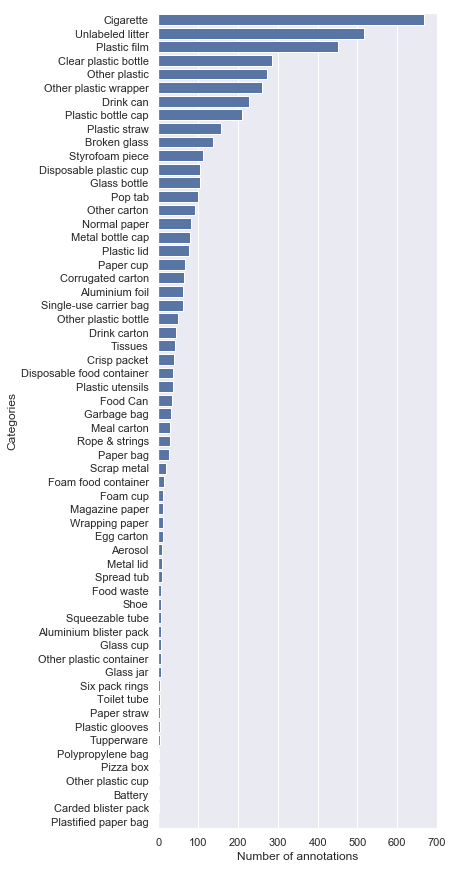

In [34]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

# fig = plot_1.get_figure()
# fig.savefig("output.png")

In [35]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [36]:
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,Aluminium foil,62.0
2,Battery,2.0
3,Aluminium blister pack,6.0
4,Carded blister pack,1.0
...,...,...
56,Plastic straw,157.0
57,Paper straw,4.0
58,Styrofoam piece,112.0
59,Unlabeled litter,517.0


## 데이터 전처리 함수 정의 (TACO Dataset)

> For convenience, annotations are provided in COCO format.

- [Trash Annotations in Context](http://tacodataset.org/)
- [Create COCO Annotations From Scratch](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch)
- [How to train an Object Detector with your own COCO dataset in PyTorch (Common Objects in Context format)](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)
- https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py

There are two different formats of storing masks in COCO protocol. (The following JSON shows 2 different annotations.)

1. **polygons format** 

    - Has a segmentation list of vertices (x, y pixel positions)
    - Has an area of 702 pixels (pretty small) and a bounding box of [473.07,395.93,38.65,28.67]
    - Is not a crowd (meaning it’s a single object)
    - Is category id of 18 (which is a dog)
    - Corresponds with an image with id 289343 (which is a person on a strange bicycle and a tiny dog)
    
    => `coco.annToMask(polygons)`


2. RLE(run-length-encoded) format

    - Has a Run-Length-Encoding style segmentation
    - Has an area of 220834 pixels (much larger) and a bounding box of [0,34,639,388]
    - Is a crowd (meaning it’s a group of objects)
    - Is a category id of 1 (which is a person)
    - Corresponds with an image with id 250282 (which is a vintage class photo of about 50 school children)

In [48]:
# Class below reads segmentation dataset in TACO compatible format.

class CoCoDataset(Dataset):
    category_len = len(sorted_df)
    category_label = list(sorted_df.index)
    category_names = list(sorted_df.Categories)
    
    def __init__(self, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        self.coco = COCO('{}/annotations.json'.format(data_dir))
        self.transforms = transforms
    
    def __getitem__(self, index: int): 
        image_id = self.coco.getImgIds(imgIds=index)
        image_info = self.coco.loadImgs(image_id)[0]
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # tensor type으로 변경 (세환님 확인 필요)
        image = torch.as_tensor(image, dtype=torch.float32)
        
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)
        
        boxes = np.array([x['bbox'] for x in anns], dtype=np.float64)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
        
        # masks : width x height size의 pixel을 가지며, 각각의 pixel 값에는 "category id + 1" 값 할당(0~60)
        # Background = 0, Aluminium foil = 1, ... , Cigarette = 60
        
#         print("image_info : {}".format(image_info))
#         print("\n")
#         print("anns : {}".format(anns))
#         print("\n")        
#         print("anns 갯수: {}".format(len(anns)))
        
        # masks initializaiton
        masks = np.zeros((image_info["height"], image_info["width"]))
        for i in range(len(anns)):
            temp_mask = self.coco.annToMask(anns[i])
            temp_mask = np.where(temp_mask == 1, labels[i]+1, temp_mask)
            masks += temp_mask
        masks = torch.as_tensor(masks, dtype=torch.long)
        
        plt.imshow(masks)
        
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds, 'masks' : masks}
        
        # transforms segmentation에서도 잘 작동하는지 확인 필요!
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'])
            
        return image, target, image_info 
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [49]:
# train data folder directory 
train_path = '../../data'

# # validation data folder directory 
# val_path = '../../data'

# # test data folder directory 
# test_path = '../../data'

In [50]:
# create own Dataset
train_dataset = CoCoDataset(data_dir=train_path)

# val_dataset = CoCoDataset(data_dir=val_path)
# test_dataset = CoCoDataset(data_dir=test_path)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [51]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# train DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = 0,
                                          collate_fn = collate_fn)

# # validation DataLoader
# val_loader = torch.utils.data.DataLoader(val_dataset,
#                                          batch_size = batch_size,
#                                          shuffle = True,
#                                          num_workers = 0,
#                                          collate_fn = collate_fn)

# # test DataLoader
# test_loader = torch.utils.data.DataLoader(test_dataset,
#                                           batch_size = batch_size,
#                                           shuffle = True,
#                                           num_workers = 0,
#                                           collate_fn = collate_fn)

### 데이터 샘플 시각화 (Show example image and mask)

`train_loader` 가 잘 작동하는지 확인하기 위함

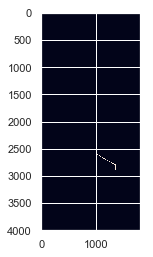

In [52]:
# DataLoader is iterable over Dataset
for imgs, targets, image_infos in train_loader:
    image_infos = image_infos[0]
    images = imgs[0]
    masks = targets[0]['masks'].numpy()
    
    break

image shape: [1824, 4000, 3]
mask shape:  [1824, 4000]


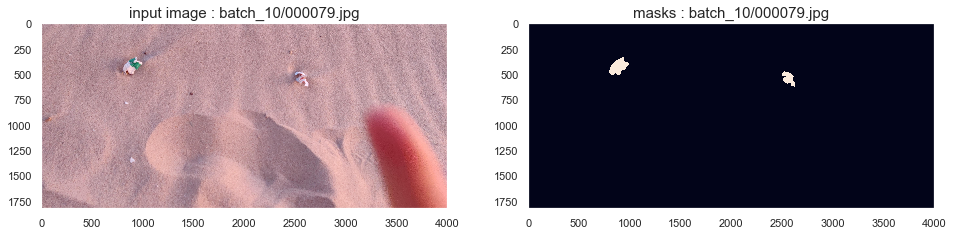

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('image shape:', list(images.shape))
print('mask shape: ', list(masks.shape))

ax1.imshow(images)
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(masks)
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [54]:
np.unique(masks)
# 겹쳐서 나오는 부분이 존재
# 방법 1
# random하게 label 한개 설정 (2개 중 1개 설정)

# 방법 2
# random 이 아닌 면적 크기 비교해서 큰 것 설정

array([ 0, 59], dtype=int64)

## 네트워크 설계 I (Pretrained 되지 않은 모델 사용) 

#### backbone - VGG 구조

![](https://drive.google.com/uc?export=view&id=1sc7Q_prm23kW2qgxBvEQgSOK35H3cqoV)

#### FCN - 구조

- FCN32 based on pretrained-VGG16  
- FCN16 based on pretrained-VGG16
- FCN8 based on pretrained-VGG16

![](https://wiki.tum.de/download/attachments/23561833/Screenshot%20from%202017-01-05%2020-29-06.png?version=1&modificationDate=1483644566733&api=v2)

### FCN32 based on VGG16

In [55]:
# 모델 참고 코드 
# https://github.com/wkentaro/pytorch-fcn/
import torch
import torch.nn as nn


class FCN32s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN32s, self).__init__()
        self.relu    = nn.ReLU(inplace=True)
        
        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 
        
        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 64, stride = 32)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        o_h, o_w = x.size()[2], x.size()[3]
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        
        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)
        
        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)
        
        h = self.score_fr(h)
        upscore32 = self.upscore32(h)  
        
        u_h, u_w = upscore32.size()[2], upscore32.size()[3]
        dh, dw = (u_h - o_h)//2, (u_w - o_w)//2
        return torch.sigmoid(upscore32[:, :, dh:(dh + o_h), dw:(dw + o_w)])

In [765]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
num_classes = CoCoDataset.category_len

model = FCN32s(num_classes)
x = torch.randn([1, 3, 224, 224])
print("input shape : ", x.shape)
out = model(x)
print("output shape : ", out.size())

input shape :  torch.Size([1, 3, 224, 224])
output shape :  torch.Size([1, 61, 224, 224])



### FCN16 based on VGG16


In [691]:
# 모델 참고 코드 
# https://github.com/wkentaro/pytorch-fcn/
import torch
import torch.nn as nn
class FCN16s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN16s, self).__init__()
        self.relu    = nn.ReLU(inplace=True)
        
        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        self.score_pool4 = nn.Conv2d(512, num_classes, 1)
    
        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 32, stride = 16)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        pool4 = h = self.pool4(h)
        
        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)
        
        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)
        
        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         
        pool4 = self.score_pool4(pool4)
        
        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore16 = self.upscore16(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])]) 
        
        dh, dw = (upscore16.size()[2] - x.size()[2])//2, (upscore16.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore16[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [693]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
num_classes = CoCoDataset.category_len

model = FCN16s(num_classes)
x = torch.randn([1, 3, 224, 224])
print("input shape : ", x.shape)
out = model(x)
print("output shape : ", out.size())

input shape :  torch.Size([1, 3, 224, 224])
output shape :  torch.Size([1, 61, 224, 224])


### FCN8 based on VGG16

In [694]:
# 모델 참고 코드 
# https://github.com/wkentaro/pytorch-fcn/
import torch
import torch.nn as nn
class FCN8s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN8s, self).__init__()
        self.relu    = nn.ReLU(inplace=True)
        
        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)
        
        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 16, stride = 8)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        pool3 = h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        pool4 = h = self.pool4(h)
        
        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)
        
        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)
        
        pool3 = self.score_pool3(pool3)
        pool4 = self.score_pool4(pool4)
        
        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         
        
        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore2_pool4 = self.upscore2_pool4(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])])
        
        dh, dw = (pool3.size()[2] - upscore2_pool4.size()[2])//2, (pool3.size()[3] - upscore2_pool4.size()[3])//2
        upscore8 = self.upscore8(upscore2_pool4 + pool3[:, :, dh:(dh + upscore2_pool4.size()[2]), dw:(dw + upscore2_pool4.size()[3])])
              
        dh, dw = (upscore8.size()[2] - x.size()[2])//2, (upscore8.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore8[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [699]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
num_classes = CoCoDataset.category_len

model = FCN8s(num_classes=21)
x = torch.randn([1, 3, 224, 224])
print("input shape : ", x.shape)
out = model(x)
print("output shape : ", out.size())

input shape :  torch.Size([1, 3, 224, 224])
output shape :  torch.Size([1, 21, 224, 224])


## Tip : VGG 네트워크(backbone) 깔끔하게 작성하는 방법

In [701]:
# VGG 16에 대한 네트워크 코드 
import torch
import torch.nn as nn


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        '''
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        '''
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7), 
            nn.ReLU(inplace=True), 
            nn.Dropout(), 
            nn.Conv2d(4096, 4096, 1), 
            nn.ReLU(inplace=True), 
            nn.Dropout(), 
            nn.Conv2d(4096, num_classes, 1),
        )#FC layer 
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [709]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
    
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64, 64, 64,'M', 128, 128, 128, 'M', 256, 256, 256, 'M']
}

## Tip : FCN 네트워크를 깔끔하게 작성하는 방법

In [703]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN32s, self).__init__()
        self.features = VGG(make_layers(cfg['D']), num_classes=20+1, init_weights=True).features
        self.features[0].padding = (100,100)
        self.features_map = nn.Sequential(*self.features)
        self.conv = nn.Sequential(nn.Conv2d(512, 4096, kernel_size = 7),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(),
                                  nn.Conv2d(4096, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout()
                                  )
        self.score_fr=nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore=nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 64, stride = 32)
        self._initialize_weights()

        
    def forward(self,x):
        #x_size = x.size()
        o_h, o_w = x.size()[2], x.size()[3]

        pool = self.conv(self.features_map(x))
        score_fr = self.score_fr(pool)
        upscore = self.upscore(score_fr)
        u_h, u_w = upscore.size()[2], upscore.size()[3]
        dh, dw = (u_h - o_h)//2, (u_w - o_w)//2
        return upscore[:, :, dh:(dh + o_h), dw:(dw + o_w)] 
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [705]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
num_classes = CoCoDataset.category_len

model = FCN32s(num_classes)
x = torch.randn([1, 3, 224, 224])
print("input shape : ", x.shape)
out = model(x)
print("output shape : ", out.size())

input shape :  torch.Size([1, 3, 224, 224])
output shape :  torch.Size([1, 61, 224, 224])


## 네트워크 설계 II (Pretrained 된 모델 사용) 

- FCN32 based on pretrained-VGG16  
- FCN16 based on pretrained-VGG16
- FCN8 based on pretrained-VGG16

In [706]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import vgg16

pretrained_model = vgg16(pretrained = True)

### FCN32 based on pretrained-VGG16  

### FCN16 based on pretrained-VGG16

### FCN8 based on pretrained-VGG16

In [707]:
class FCN8(nn.Module):
    def __init__(self, num_classes):
        super(FCN8,self).__init__()
        self.pretrained_model = vgg16(pretrained = True)
        features, classifiers = list(self.pretrained_model.features.children()), list(self.pretrained_model.classifier.children())

        features[0].padding = (100,100)
        self.features_map = nn.Sequential(*features)
        self.conv = nn.Sequential(nn.Conv2d(512, 4096, kernel_size = 7),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(),
                                  nn.Conv2d(4096, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout()
                                  )
        
        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)
        
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 16, stride = 8)

        
    def forward(self,x):
        pool = self.conv(self.features_map(x))
        score_fr = self.score_fr(pool)
        upscore = self.upscore(score_fr)
        u_h, u_w = upscore.size()[2], upscore.size()[3]
        dh, dw = (u_h - o_h)//2, (u_w - o_w)//2
        return upscore[:, :, dh:(dh + o_h), dw:(dw + o_w)]   # 현우님의 feedback 받아 수정 필요
    
    def forward(self, x):
        h = self.conv(self.features_map(x))
        pool4 = self.score_pool4(pool4)
        
        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         
        
        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore2_pool4 = self.upscore2_pool4(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])])
        
        dh, dw = (pool3.size()[2] - upscore2_pool4.size()[2])//2, (pool3.size()[3] - upscore2_pool4.size()[3])//2
        upscore8 = self.upscore8(upscore2_pool4 + pool3[:, :, dh:(dh + upscore2_pool4.size()[2]), dw:(dw + upscore2_pool4.size()[3])])
              
        dh, dw = (upscore8.size()[2] - x.size()[2])//2, (upscore8.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore8[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [708]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
num_classes = CoCoDataset.category_len

model = FCN8(num_classes=22)
x = torch.randn([1, 3, 224, 224])
print("input shape : ", x.shape)
out = model(x)
print("output shape : ", out.size())

input shape :  torch.Size([1, 3, 224, 224])


UnboundLocalError: local variable 'pool4' referenced before assignment

## train, validation, test 함수 정의

In [56]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for step, (images, targets, _) in enumerate(data_loader):
            print(targets[0]["masks"].shape)
            print('------------')
            images, masks = images[0].to(device), targets[0]["masks"].to(device)
            
            outputs = model(images)
            print('------------')
            print(masks[0].shape)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
                
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, cross_entropy2d, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [57]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (images, targets, _) in enumerate(data_loader):
            images, masks = images[0].to(device), targets[0]["masks"].to(device)
            outputs = model(images)
            loss = criterion(outputs, mask)
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}'.format(epoch, avrg_loss))
   
    model.train()
    return avrg_loss

## 모델 저장 함수 정의

In [58]:
def save_model(model, saved_dir, file_name='model.pt'):
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

- [다중분류를 위한 대표적인 손실함수 : `torch.nn.CrossEntropyLoss`](http://www.gisdeveloper.co.kr/?p=8668)
- [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [59]:
import torch
import torch.nn as nn

torch.manual_seed(7777)

batch_size = 3    
nb_classes = 61
h, w = 24, 24
output = torch.randn(batch_size, nb_classes, h, w)
print(output.shape)
target = torch.empty(batch_size, h, w, dtype=torch.long).random_(nb_classes)
print(target.shape)
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
print(loss)

torch.Size([3, 61, 24, 24])
torch.Size([3, 24, 24])
tensor(4.6275)


In [60]:
import torch
import torch.nn as nn

batch_size = 1    
nb_classes = 5
h, w = 2, 2
output = torch.randn(batch_size, nb_classes, h, w)
target = torch.empty(batch_size, h, w, dtype=torch.long).random_(nb_classes)
criterion = nn.NLLLoss()
loss = criterion(output, target)
print(loss)

tensor(0.8560)


In [64]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [65]:
# model 정의
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
num_classes = CoCoDataset.category_len

model = FCN32s(num_classes)
model = model.to(device)

val_every = 1
saved_dir = './saved/FCN32'

## training

Start training..
torch.Size([4032, 3024])
------------


IndexError: tuple index out of range

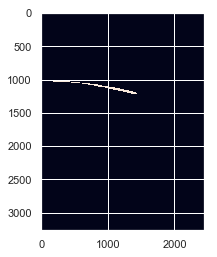

In [66]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

## Test

## 저장된 model 불러오기